In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
with open('./data/trump_speeches.txt', 'r', encoding='utf-8') as f:
    data = f.read()

In [38]:
df = pd.read_csv('./data/names.csv')
data = ' '.join(df.name.tolist())

In [39]:
# data I/O
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 237097 characters, 53 unique.


In [40]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [41]:
X_train = np.zeros((len(data), len(chars)))

In [42]:
char_id = np.array([chars.index(c) for c in data])

In [43]:
X_train[np.arange(len(X_train)), char_id] = 1

In [44]:
y_train = np.roll(char_id,-1)

In [45]:
X_train.shape

(237097, 53)

In [46]:
y_train.shape

(237097,)

## Build a RNN model

In [47]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc_x = nn.Linear(input_size, hidden_size)
        self.fc_h = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, h):
        x_out = self.fc_x(X)
        h_out = self.fc_h(h)
        h_new = self.tanh(x_out + h_out)
        out = self.fc_out(h_new)
        
        return out, h_new
    
    def init_h(self):
        return torch.zeros(self.fc_x.out_features)

In [48]:
#rnn(torch.from_numpy(X_train[0]).float(), torch.zeros(128))

In [87]:
rnn = CharRNN(vocab_size, hidden_size, vocab_size)

In [88]:
loss_fn = nn.CrossEntropyLoss()

In [89]:
optimizer = torch.optim.Adagrad(rnn.parameters(), lr=0.1)

In [90]:
def get_batch(X=X_train, y=y_train, batch_size=seq_length):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    for i in range(0, len(y), batch_size):   
        id_stop = i+batch_size if i+batch_size < len(X) else len(X)
        yield([X[i:id_stop], y[i:id_stop]])

In [91]:
def sample_chars(X_seed, h_prev, length=20):
    for p in rnn.parameters():
        p.requires_grad = False
    X_next = X_seed
    results = []
    for i in range(length):        
        y_score, h_prev = rnn(X_next, h_prev)
        y_prob = nn.Softmax(0)(y_score).detach().numpy()
        y_pred = np.random.choice(chars,1, p=y_prob).item()
        results.append(y_pred)
        X_next = torch.zeros_like(X_seed)
        X_next[chars.index(y_pred)] = 1
        #print(f'{i} th char:{y_pred}')
    for p in rnn.parameters():
        p.requires_grad = True
    return ''.join(results)

In [92]:
for epoch in range(100):
    losses = []
    h_prev = rnn.init_h()
    for batch in get_batch(X_train, y_train, seq_length):   
        X_batch, y_batch = batch        
        optimizer.zero_grad()   
        loss_batch = 0
        for ch_id in range(len(X_batch)):
            y_score, h_prev = rnn(X_batch[ch_id], h_prev)            
            loss = loss_fn(y_score.view(1,-1), y_batch[ch_id].view(1))
            loss_batch += loss
            losses.append(loss.item())                    
            

            if len(losses)%1000==0:
                print(f'Running Avg Loss:{np.mean(losses[-1000:])} at epoch: {epoch}')  
                print(sample_chars(X_batch[ch_id], h_prev, 200))
        loss_batch.backward(retain_graph=True)
        if len(losses)%100==0:
            print(f'Batch Loss:{loss_batch} at iter: {len(losses)}')  
        optimizer.step()

Batch Loss:243.45196533203125 at iter: 100
Batch Loss:211.6631317138672 at iter: 200
Batch Loss:97.08665466308594 at iter: 300
Batch Loss:80.84259796142578 at iter: 400
Batch Loss:104.28507995605469 at iter: 500
Batch Loss:90.72129821777344 at iter: 600
Batch Loss:94.93860626220703 at iter: 700
Batch Loss:81.6021728515625 at iter: 800
Batch Loss:91.24391174316406 at iter: 900
Running Avg Loss:4.477949078124016 at epoch: 0
wWBWwWwWwWwlwWwuwWwWwWwWy wWwehawWwEwWwWwWwr Wwtw wWwWyWwWwWwawW Ww wawWw wWwWwWwlwSwWabwWwWw wawWwWwawWwWw wWwawWwWwewCwOwWwn owWy eWwawWwWwWiWyWwWwWwewWwWwWwWwlyWwaAWptwWw wawhwWwqwWwWlbwWwWhawWwWHa
Batch Loss:112.81448364257812 at iter: 1000
Batch Loss:78.47531127929688 at iter: 1100
Batch Loss:73.13815307617188 at iter: 1200
Batch Loss:84.01350402832031 at iter: 1300
Batch Loss:78.05994415283203 at iter: 1400
Batch Loss:85.625 at iter: 1500
Batch Loss:83.95088958740234 at iter: 1600
Batch Loss:79.13963317871094 at iter: 1700
Batch Loss:73.60279846191406 at iter: 1

KeyboardInterrupt: 

(array([ 2.,  6., 13., 11., 14., 13., 14., 10., 10.,  7.]),
 array([-0.90790421, -0.73041324, -0.55292227, -0.37543131, -0.19794034,
        -0.02044937,  0.1570416 ,  0.33453256,  0.51202353,  0.6895145 ,
         0.86700547]),
 <a list of 10 Patch objects>)

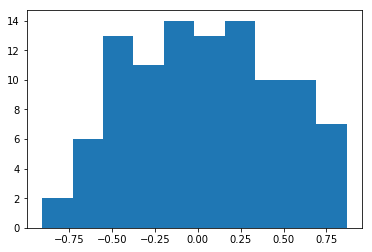

In [67]:
plt.hist(h_prev.detach().numpy())

In [31]:
X_seed = X_batch[ch_id]

In [32]:
print(sample_chars(X_seed, rnn.init_h(), 10000))

 deand I dron. Thinte all now, weill peoth tile nhelnd de afy grree gop lome fale the ghe to fen’ see thaende fuv.
trewerpe eorl do Iof fe lerss.
Shey’meashas ushp vory redy thr in.
I gops ot ge I Ie thes gone gim wevh ge in dig sadte hing venday melshat wad jbe gasile the osre dedibig ens ind than si kanth and a ledt rec ca to lon hing ind I’d tily eveathe le ceoi ge nopal ope peeng.
Anie dedsof whes dei keled Ishane,’reess demen that the someshcppin thae toult.
Anet he ge gocpopled I gop.
I oull ber beond wipe yomt’tresve, tupre toule he’r died I’’s o at old It thany Sgos haver thrySe the inag bidte I sa – I’veae gor.
I’red reter fing lalt noige thantintian emo wol an It sus wha evy chat he nhad igry necp k.
"ind geantr at doaut maledl whanr ofeo lid lectpeeshe she I at snd precand oud boly ibed h teln youd I dow.
I they calerton pom aple.
in. I I wo touse soo kike bey the looma ruys gad.
Bore goded tomnn dou kan gyhe .
Yowe’s dot tit’s Ir cobend picre gous. drend herl giak onot shou

In [37]:
for p in rnn.parameters():
    print(p.grad.mean())

tensor(1.00000e-05 *
       -4.3225)
tensor(1.00000e-03 *
       -4.0199)
tensor(1.00000e-04 *
       7.4434)
tensor(1.00000e-03 *
       -4.0199)
tensor(1.00000e-11 *
       1.1821)
tensor(1.00000e-10 *
       1.4043)


In [1]:
import torch

In [11]:
w = torch.tensor([[2,3],[4,5]], dtype=torch.float, requires_grad=True)

In [12]:
x = torch.tensor([[7,3],[3,6],[6,9]], dtype=torch.float, requires_grad=True)

In [13]:
wx = torch.mm(x,w)

In [14]:
s1 = wx.sum()

In [15]:
s1.backward()

In [16]:
w.grad

tensor([[ 16.,  16.],
        [ 18.,  18.]])

In [17]:
x.grad

tensor([[ 5.,  9.],
        [ 5.,  9.],
        [ 5.,  9.]])

In [18]:
wx

tensor([[ 26.,  36.],
        [ 30.,  39.],
        [ 48.,  63.]])

In [ ]:
w2 = torch.mm(wx,)

In [17]:
Wxh.shape

(100, 53)

In [18]:
Whh.shape

(100, 100)

In [19]:
Why.shape

(53, 100)

In [20]:
bh.shape

(100, 1)

In [10]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [11]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [12]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [21]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

In [28]:
inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

In [30]:
hprev.shape

(100, 1)

In [31]:
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0

In [32]:
t = 0

In [34]:
xs[t] = np.zeros((vocab_size,1))

In [37]:
xs[t][inputs[t]] = 1

In [41]:
np.dot(Wxh, xs[t]).shape

(100, 1)

In [49]:
hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)

In [52]:
import matplotlib.pyplot as plt
% matplotlib inline

In [59]:
ys[t] = np.dot(Why, hs[t]) + by

In [61]:
ys[t].shape

(53, 1)

In [62]:
ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

In [73]:
-np.log(1.0/3000)*50

400.3183783825123

In [74]:
hprev = hs[t-1]

In [79]:
''.join(ix_to_char[ix] for ix in sample(hprev, 1, 200))

'ikama enaliia Janden Celen Badkia Darine Jumah Jagkida Asmyanat Caima Ediouy Inriserya Janieghebe Jame Giyne Jozabkatgh Alance Jomvi Jorielya Eyah Aillana Kateliuh Babye Makjan Calisse Tynnibele Jaigz'

In [81]:
seed_ix = 1

In [82]:
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []

In [84]:
x.shape

(53, 1)

In [86]:
h = hprev

In [115]:
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)

In [116]:
ix

7

In [120]:
x.shape

(53, 1)

In [121]:
Wxh.shape

(100, 53)

In [122]:
np.dot(Wxh, x).shape

(100, 1)

In [126]:
Wxh.shape

(100, 53)

In [48]:
np.log(vocab_size)*25

99.25729783880305

In [45]:
seq_length

25

In [49]:
hprev = np.zeros((hidden_size,1))

In [51]:
hprev.shape

(100, 1)

In [52]:
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

In [54]:
data[p:p+seq_length]

'Emma Olivia Sophia Isabel'

In [55]:
data[p+1:p+seq_length+1]

'mma Olivia Sophia Isabell'

In [56]:
inputs[0]

44

In [64]:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

----
 PfKTwPfmTLjbeVZCLEYRbGltieocPNNtsnTWVZNjehJnZLQRvvrMFQNpxCxHQncWpvjBYZYqasQfIdjPqtrPTEYDcCOxngJamYZCVpjyxVEIQRCbvbqpYtPM ZNVXcNiIDRixwFDVnkWUscUzu juwCkYuBqHeUVcyiWELKcoIr nr TKNCDpxLGyyKENSvJnmvweRQQ 
----


In [66]:
loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)

In [100]:
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0

In [101]:
t=0

In [102]:
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

In [141]:
hs[-1].shape

(100, 1)

In [138]:
ps[t][targets[t]][0]

0.0398582039920804

In [132]:
ps[t]

array([[1.22462687e-02],
       [3.70884873e-04],
       [1.47718282e-01],
       [4.91778089e-04],
       [1.43579039e-02],
       [1.94613594e-03],
       [3.98582040e-02],
       [1.83239784e-03],
       [1.40377295e-03],
       [2.25524356e-03],
       [1.86338027e-02],
       [1.82163330e-03],
       [1.36034842e-03],
       [5.34832575e-03],
       [5.31882994e-03],
       [2.56723943e-02],
       [2.08954666e-01],
       [1.67814105e-04],
       [5.43953948e-02],
       [1.23416029e-02],
       [2.71522941e-02],
       [7.07506732e-04],
       [3.90479874e-03],
       [3.07619937e-03],
       [6.03594339e-04],
       [2.60599790e-02],
       [3.70108202e-05],
       [2.20467155e-03],
       [8.62683131e-03],
       [6.98119822e-04],
       [5.34681858e-03],
       [2.66708994e-03],
       [1.11460252e-02],
       [1.62131224e-03],
       [4.59798728e-03],
       [2.41688939e-03],
       [7.15391514e-04],
       [1.00846412e-03],
       [7.64864017e-04],
       [1.19025338e-02],


In [126]:
ps[t].argmax()

16

In [117]:
Wxh[:,10]

array([-0.11848706, -0.05649749,  0.02691294,  0.19014995,  0.07061441,
       -1.16252144,  0.12697324, -0.08889963, -0.06267175, -0.40105323,
       -0.18747102, -0.18140617,  0.07432117,  0.34334437,  0.06726984,
        0.20165935,  0.32747234,  0.04495337,  0.1142929 , -0.05521551,
        0.00885307,  0.33516984,  0.13067932, -0.10904185,  0.19814699,
        0.0913149 , -0.06236525, -0.01253117,  0.41185781, -0.3912567 ,
       -0.1494085 ,  0.36435163, -0.44824475, -0.09278199,  0.34402929,
       -0.15928979, -0.26921809,  0.05811367, -0.13787257,  0.20121986,
        0.01388096,  0.07998907,  0.05387593,  0.0689815 ,  0.26390591,
        0.0065182 , -0.09641561,  0.20798219,  0.07988806,  0.20825779,
       -0.26811509, -0.03696904, -0.16780612, -0.38446364,  0.28463213,
        0.14157797, -0.19357392, -0.16630077,  0.11378831,  0.25725707,
        0.17818427,  0.008875  , -0.06520907,  0.12799508,  0.22632408,
       -0.17792747,  0.19119546, -0.04671774, -0.45145593,  0.05

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

In [ ]:
df = pd